In [4]:
from glob import glob as glob
import itertools

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *
from helperfuns_dualPM import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### TODO
- train on ntrials=1

### init

In [30]:
# task sweep params
num_back = 1
num_pm_maps = 2
seed = 0

## initialize
task = TaskDualPM(num_back=num_back,num_pm_maps=num_pm_maps,seed=seed)
net = NetDualPM(seed=seed)b

### train

In [4]:
num_trials_tr = 2
trial_len_tr = 15
neps_tr = 20000
tr_acc = train_net(net,task,
               neps=neps_tr,
               num_trials=num_trials_tr,
               trial_len=trial_len_tr
              )

plt.plot(tr_acc)

### eval

In [7]:
net,task = load_net_and_task(1,2,1)
ev_acc = eval_net(net,task)
trial_len=15

plt.figure(figsize=(10,3))
ax = plt.gca()

ax.plot(ev_acc)
ax.scatter(range(len(ev_acc)),ev_acc)

ax.axvline(trial_len+num_pm_maps-.5,c='purple')
for pm_pos in np.array([3,7])+num_pm_maps:
  ax.axvline(pm_pos,c='green',ls='--')
  ax.axvline(pm_pos+trial_len+num_pm_maps,c='green',ls='--')

NameError: name 'maxsoftmax' is not defined

## group acc plot

In [11]:
num_back = 3
pm_maps = 2

nnets = 5
tr_len = 15
num_trials = 2

exp_len = num_trials*(pm_maps+tr_len)
acc = -np.ones([nnets,exp_len])
for seed in range(nnets):
  net,task = load_net_and_task(num_back,pm_maps,seed)
  acc[seed] = eval_net(net,task,trial_len=tr_len,num_trials=num_trials,og_bias=[10,100])

M = acc.mean(0)
S = acc.std(0)/np.sqrt(nnets)

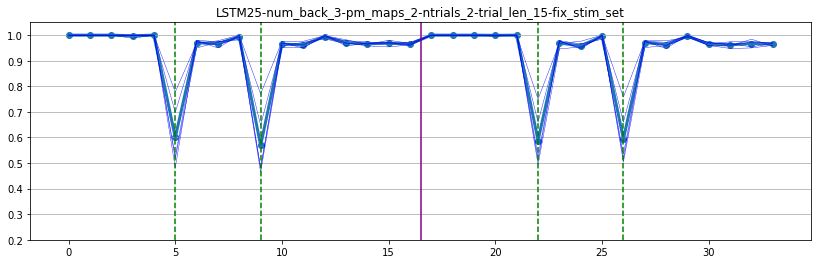

In [12]:
plt.figure(figsize=(14,4))
ax = plt.gca()

# plot
ax.plot(M,lw=3)
ax.scatter(range(exp_len),M)
for sacc in acc:
  plt.plot(sacc, c='b',lw=.4)

# trial boundary and PM probes
ax.axvline(tr_len+pm_maps-.5,c='purple')
for pm_pos in np.array([3,7])+pm_maps:
  ax.axvline(pm_pos,c='green',ls='--')
  ax.axvline(pm_pos+tr_len+pm_maps,c='green',ls='--')

# figure
ax.set_ylim(0.2,1.05)
plt.grid(axis='y')
title = "LSTM25-num_back_%i-pm_maps_%i-ntrials_2-trial_len_15-fix_stim_set"%(num_back,pm_maps)
ax.set_title(title)

# plt.savefig("figures/DualPM_sweep1-fixstimset/"+title)

### breakdown of accuracy

In [4]:
num_back = 1
num_pm_maps = 3

nnets = 5
acc = -np.ones([nnets,3])
for seed in range(nnets):
  net,task = load_net_and_task(num_back,num_pm_maps,seed)
  score = eval_byprobe(net,task,neps_ev=500,num_trials=1,trial_len=20)
  acc[seed] = score.mean(1)


In [6]:
pm_maps = num_pm_maps

Text(0.5,1,'LSTM25-num_back_1-pm_maps_3-ntrials_2-trial_len_15-fix_stim_set')

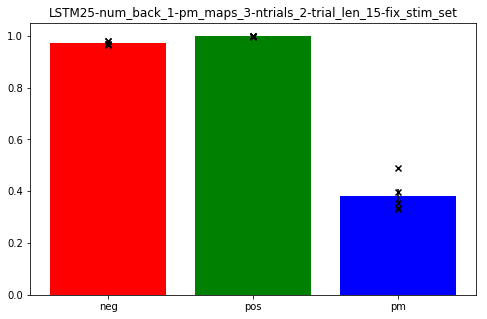

In [7]:
plt.figure(figsize=(8,5))
ax = plt.gca()
M = acc.mean(0)
S = acc.std(0)/np.sqrt(nnets)

ax.bar(['neg','pos','pm'],M,yerr=S,color=['red','green','blue'])
for sacc in acc:
  ax.scatter([0,1,2],sacc,c='black',marker='x',zorder=3)
  
ax.set_ylim(0,1.05)  
title = "LSTM25-num_back_%i-pm_maps_%i-ntrials_2-trial_len_15-fix_stim_set"%(num_back,pm_maps)
ax.set_title(title)
# plt.savefig("figures/DualPM_sweep1-fixstimset/bar-"+title)

# pure PM 

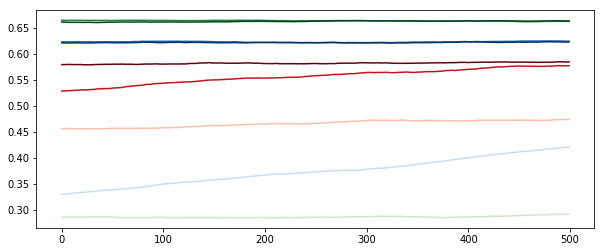

In [38]:
# task params
num_back = 1

num_trials = 1
trial_len = 5

plt.figure(figsize=(10,4))
cL = [plt.cm.Reds,plt.cm.Blues,plt.cm.Greens]
for pmm_idx,pmmaps in enumerate([4,6,8]):
  for ss_idx,ss in enumerate([3,10,50]):
    net = NetDualPM(stsize=ss)
    task = TaskDualPM(num_back=num_back,num_pm_maps=pmmaps,num_stim_tokens=ns)
    gen_data_fn = lambda: task.gen_ep_data(
        num_trials=1,
        trial_len=trial_len,
        pm_probe_positions_=range(trial_len)
    )
    i,x,y = gen_data_fn()
    tracc = train_net(net,task,neps=2000,gen_data_fn=gen_data_fn)
    plt.plot(mov_avg(tracc[500:],1000),label=ss,c=cL[pmm_idx](ss*20))
